In [1]:
pip install numpy pandas matplotlib scikit-learn tensorflow seaborn joblib imbalanced-learn xgboost jupyterlab


   ---------------------------------------- 4/4 [isoduration]

Note: you may need to restart the kernel to use updated packages.


PART 1: VITAL SIGNS ANOMALY DETECTION (LSTM)
Successfully loaded vitals dataset: .\human_vitals/human_vital_signs_dataset_2024.csv
Vitals dataset columns: ['Patient ID', 'Heart Rate', 'Respiratory Rate', 'Timestamp', 'Body Temperature', 'Oxygen Saturation', 'Systolic Blood Pressure', 'Diastolic Blood Pressure', 'Age', 'Gender', 'Weight (kg)', 'Height (m)', 'Derived_HRV', 'Derived_Pulse_Pressure', 'Derived_BMI', 'Derived_MAP', 'Risk Category']

Sample Vitals Data (first 5 rows):
   Heart Rate  Oxygen Saturation  Body Temperature
0          60          95.702046         36.861707
1          63          96.689413         36.511633
2          63          98.508265         37.052049
3          99          95.011801         36.654748
4          69          98.623792         36.975098

Descriptive Statistics for Vitals:
          Heart Rate  Oxygen Saturation  Body Temperature
count  200020.000000      200020.000000     200020.000000
mean       79.533747          97.504372         36.748353
s

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 10, 128)             │          67,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 117,122 (457.51 KB)

 Trainable params: 117,122 (457.51 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM model for vitals...
Epoch 1/20
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 44s 16ms/step - accuracy: 0.8952 - loss: 0.3700 - val_accuracy: 0.9908 - val_loss: 0.0739
Epoch 2/20
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - accuracy: 0.9752 - loss: 0.0911 - val_accuracy: 0.9614 - val_loss: 0.1163
Epoch 3/20
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - accuracy: 0.9785 - loss: 0.0793 - val_accuracy: 0.9907 - val_loss: 0.0543
Epoch 4/20
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 50s 20ms/step - accuracy: 0.9826 - loss: 0.0672 - val_accuracy: 0.9909 - val_loss: 0.0514
Epoch 5/20
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 50s 20ms/step - accuracy: 0.9855 - loss: 0.0583 - val_accuracy: 0.9952 - val_loss: 0.0440
Epoch 6/20
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 52s 21ms/step - accuracy: 0.9868 - loss: 0.0536 - val_accuracy: 0.9900 - val_loss: 0.0456
Epoch 7/20
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - accuracy: 0.9870 - loss: 0.0523 - val_accuracy: 0.9762 - val_loss: 0.0677
Epoch 8/20
2501/2501 ━━━━━━━━━━━━━━━━━━━━

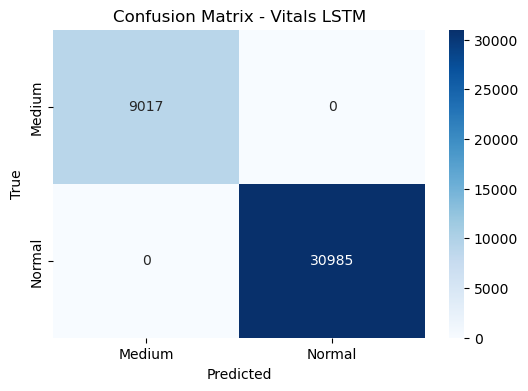

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, make_scorer,
                             recall_score, f1_score)
import seaborn as sns
import os
import joblib

# TensorFlow / Keras
from tensorflow.keras.models import Sequential, load_model # Added load_model here for clarity if needed later
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight

# Imbalanced-learn for SMOTE
try:
    from imblearn.over_sampling import SMOTE
    IMBLEARN_AVAILABLE = True
except ImportError:
    IMBLEARN_AVAILABLE = False
    print("Warning: imbalanced-learn (for SMOTE) is not installed. SMOTE will be skipped.")

# XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("Warning: xgboost is not installed. XGBoost model will be skipped.")

# --- Configuration ---
BASE_DATA_DIR = '.'
VITALS_DATASET_PATH = os.path.join(BASE_DATA_DIR, 'human_vitals/human_vital_signs_dataset_2024.csv')
FALL_DATASET_PATH = os.path.join(BASE_DATA_DIR, 'fall_detection_acc_gyr/acc_gyr.csv')

TIME_STEPS_VITALS = 10
N_FEATURES_VITALS = 3
N_CLASSES_VITALS = 4 # Default, will be adjusted

FALL_FEATURE_COLS_RAW = ['xAcc', 'yAcc', 'zAcc', 'xGyro', 'yGyro', 'zGyro']
FALL_LABEL_COL = 'label'
WINDOW_SIZE_SECONDS = 1.5
SAMPLING_RATE_HZ = 50
WINDOW_SAMPLES = int(WINDOW_SIZE_SECONDS * SAMPLING_RATE_HZ)
STEP_SAMPLES = WINDOW_SAMPLES // 2

# --- Helper Functions (Identical) ---
def plot_roc_curve_custom(y_true, y_pred_proba, model_name="Model", ax=None):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)
    plot_ax = ax if ax is not None else plt.gca()
    plot_ax.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})')
    plot_ax.plot([0, 1], [0, 1], 'k--'); plot_ax.set_xlabel('False Positive Rate'); plot_ax.set_ylabel('True Positive Rate')
    plot_ax.set_title(f'ROC Curve - {model_name}'); plot_ax.legend(loc='lower right'); plot_ax.grid(True)
    if ax is None: plt.show()

def plot_precision_recall_curve_custom(y_true, y_pred_proba, model_name="Model", ax=None):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    plot_ax = ax if ax is not None else plt.gca()
    plot_ax.plot(recall, precision, label=model_name)
    plot_ax.set_xlabel('Recall'); plot_ax.set_ylabel('Precision')
    plot_ax.set_title(f'Precision-Recall Curve - {model_name}'); plot_ax.legend(loc='lower left'); plot_ax.grid(True)
    if ax is None: plt.show()

# ==============================================================================
# PART 1: VITAL SIGNS ANOMALY DETECTION (LSTM)
# ==============================================================================
print("========================================================")
print("PART 1: VITAL SIGNS ANOMALY DETECTION (LSTM)")
print("========================================================")

vitals_full_df = None
model_vitals_lstm = None # Initialize to None
scaler_vitals = None     # Initialize to None
label_encoder_vitals = None # Initialize to None

try:
    if not os.path.exists(VITALS_DATASET_PATH):
        raise FileNotFoundError(f"Vitals dataset file not found at '{VITALS_DATASET_PATH}'.")
    vitals_full_df = pd.read_csv(VITALS_DATASET_PATH)
    print(f"Successfully loaded vitals dataset: {VITALS_DATASET_PATH}")
    print("Vitals dataset columns:", vitals_full_df.columns.tolist())
    print("\nSample Vitals Data (first 5 rows):"); print(vitals_full_df[['Heart Rate', 'Oxygen Saturation', 'Body Temperature']].head())
    print("\nDescriptive Statistics for Vitals:"); print(vitals_full_df[['Heart Rate', 'Oxygen Saturation', 'Body Temperature']].describe())
except FileNotFoundError as e:
    print(f"Error: {e}. Generating DUMMY vitals dataset...")
    n_rows = 2000
    vitals_full_df = pd.DataFrame({'Heart Rate': np.random.randint(50,120,n_rows), 'Oxygen Saturation': np.random.randint(90,101,n_rows), 'Body Temperature': np.random.normal(36.8,0.5,n_rows).round(1)})
    vitals_full_df['Body Temperature'] = np.clip(vitals_full_df['Body Temperature'], 35.0, 41.0); print("Loaded DUMMY vitals dataset.")
except Exception as e:
    print(f"An error occurred while loading vitals dataset: {e}"); vitals_full_df = None

if vitals_full_df is not None:
    vitals_columns_for_lstm = ['Heart Rate', 'Oxygen Saturation', 'Body Temperature']
    if not all(col in vitals_full_df.columns for col in vitals_columns_for_lstm):
        print(f"Error: Vital columns {vitals_columns_for_lstm} not found."); vitals_full_df = None

if vitals_full_df is not None:
    vitals_df_lstm = vitals_full_df[vitals_columns_for_lstm].copy()
    def create_risk_labels_vitals(df_in): # YOU MUST REVIEW/ADJUST THESE THRESHOLDS
        df = df_in.copy()
        conditions = [
            (df['Heart Rate'] > 100) | (df['Heart Rate'] < 50) | (df['Oxygen Saturation'] < 90),
            (df['Heart Rate'] > 90)  | (df['Heart Rate'] < 60) | (df['Oxygen Saturation'] < 94),
            (df['Body Temperature'] > 37.5) | (df['Body Temperature'] < 36.0)]
        risk_values = ['High', 'Medium', 'Low']; df['Risk'] = np.select(conditions, risk_values, default='Normal')
        return df['Risk']
    vitals_df_lstm['Risk'] = create_risk_labels_vitals(vitals_df_lstm)
    print("\nVitals Risk distribution:"); print(vitals_df_lstm['Risk'].value_counts(normalize=True)); print(vitals_df_lstm['Risk'].value_counts())

    label_encoder_vitals = LabelEncoder(); vitals_df_lstm['Risk_Encoded'] = label_encoder_vitals.fit_transform(vitals_df_lstm['Risk'])
    joblib.dump(label_encoder_vitals, 'vitals_risk_label_encoder.pkl'); print("Vitals Risk Label Encoder classes:", label_encoder_vitals.classes_)
    N_CLASSES_VITALS_ACTUAL = len(label_encoder_vitals.classes_)
    if N_CLASSES_VITALS_ACTUAL != N_CLASSES_VITALS:
        print(f"Adjusting N_CLASSES_VITALS from {N_CLASSES_VITALS} to {N_CLASSES_VITALS_ACTUAL}.")
        N_CLASSES_VITALS = N_CLASSES_VITALS_ACTUAL

    features_to_scale_vitals = vitals_df_lstm[vitals_columns_for_lstm].values
    scaler_vitals = StandardScaler(); scaled_features_vitals = scaler_vitals.fit_transform(features_to_scale_vitals)
    joblib.dump(scaler_vitals, 'vitals_scaler.pkl')

    def create_sequences_lstm(input_data, target_data, time_steps):
        Xs, ys = [], [];
        for i in range(len(input_data) - time_steps): Xs.append(input_data[i:(i + time_steps)]); ys.append(target_data[i + time_steps -1])
        return np.array(Xs) if Xs else np.array([]), np.array(ys) if ys else np.array([])
    X_vitals, y_vitals = create_sequences_lstm(scaled_features_vitals, vitals_df_lstm['Risk_Encoded'].values, TIME_STEPS_VITALS)

    if X_vitals.shape[0] < 50 or N_CLASSES_VITALS < 2: print(f"Skipping Vitals LSTM training (Seq: {X_vitals.shape[0]}, Cls: {N_CLASSES_VITALS}).")
    else:
        X_train_v, X_test_v, y_train_v, y_test_v = train_test_split(X_vitals, y_vitals, test_size=0.2, random_state=42, stratify=y_vitals if np.unique(y_vitals).size > 1 else None)
        keras_class_weights_dict_v = None
        if N_CLASSES_VITALS > 1 and len(np.unique(y_train_v)) >=2:
            try:
                weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_v), y=y_train_v)
                keras_class_weights_dict_v = dict(enumerate(weights)); print("Keras Class Weights for Vitals:", keras_class_weights_dict_v)
            except ValueError as e_cw: print(f"Keras class weights error: {e_cw}. Using uniform.")
        else: print("Uniform Keras weights for Vitals.")

        model_vitals_lstm = Sequential([Input(shape=(TIME_STEPS_VITALS, N_FEATURES_VITALS)), LSTM(128, return_sequences=True, kernel_regularizer='l2'), Dropout(0.3), LSTM(64, kernel_regularizer='l2'), Dropout(0.3), Dense(N_CLASSES_VITALS, activation='softmax')])
        model_vitals_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']); model_vitals_lstm.summary()
        early_stopping_vitals = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1) # Reduced patience slightly for faster iteration if needed
        
        print("\nTraining LSTM model for vitals...")
        history_vitals = model_vitals_lstm.fit(X_train_v, y_train_v, 
                                               epochs=20, # <<<--- CHANGED EPOCHS TO 20
                                               batch_size=64, validation_data=(X_test_v, y_test_v), callbacks=[early_stopping_vitals], class_weight=keras_class_weights_dict_v, verbose=1)
        model_vitals_lstm.save('vital_signs_lstm_model.keras'); print("Trained Vitals LSTM model saved.")
        print("\nEvaluating Vitals LSTM model..."); loss_v, acc_v = model_vitals_lstm.evaluate(X_test_v, y_test_v, verbose=0); print(f"Vitals LSTM Test Loss: {loss_v:.4f}, Test Accuracy: {acc_v:.4f}")
        pred_proba_v = model_vitals_lstm.predict(X_test_v); pred_encoded_v = np.argmax(pred_proba_v, axis=1)
        print("\nClassification Report (Vitals LSTM):"); target_names_report_v = label_encoder_vitals.classes_; labels_report_v = np.arange(len(target_names_report_v)); print(classification_report(y_test_v, pred_encoded_v, labels=labels_report_v, target_names=target_names_report_v, zero_division=0, digits=4))
        cm_v = confusion_matrix(y_test_v, pred_encoded_v, labels=labels_report_v); plt.figure(figsize=(max(6,N_CLASSES_VITALS*2),max(4,N_CLASSES_VITALS*1.5))); sns.heatmap(cm_v, annot=True, fmt='d', cmap='Blues', xticklabels=target_names_report_v, yticklabels=target_names_report_v); plt.title('Confusion Matrix - Vitals LSTM'); plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()
else:
    print("Vitals data processing was skipped due to earlier errors. Vitals model not trained.")


PART 2: ADVANCED FALL DETECTION (ACCELEROMETER/GYROSCOPE)

Attempting to load fall dataset from: .\fall_detection_acc_gyr/acc_gyr.csv
Successfully loaded fall dataset: .\fall_detection_acc_gyr/acc_gyr.csv
Fall dataset (raw) columns: ['xAcc', 'yAcc', 'zAcc', 'xGyro', 'yGyro', 'zGyro', 'label']

Original unique values in 'label' (before binary conversion, if applicable): ['fall' 'rfall' 'lfall' 'light' 'sit' 'walk' 'step']

Converted 'label' to binary (1 for fall, 0 for non-fall).
RAW Binary 'label' distribution:
label
0    0.710744
1    0.289256
Name: proportion, dtype: float64
label
0    68800
1    28000
Name: count, dtype: int64

Extracting windowed features (Window: 75, Step: 37)...
Extracted features from 2615 windows.

Featured 'label' distribution (after windowing):
label
0    0.710899
1    0.289101
Name: proportion, dtype: float64
label
0    1859
1     756
Name: count, dtype: int64
Saved 25 fall feature names for inference: ['SMV_Acc_mean', 'SMV_Acc_std', 'SMV_Acc_min', 'SMV_Acc

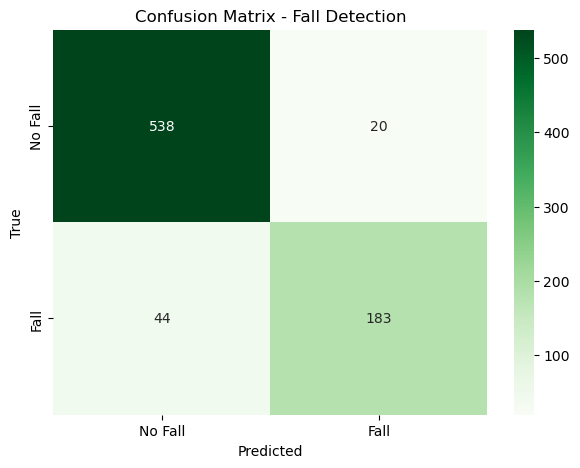


--- Visualizing Raw Sensor Data for Prediction Outcomes ---

Plotting True Positive (found 183)...


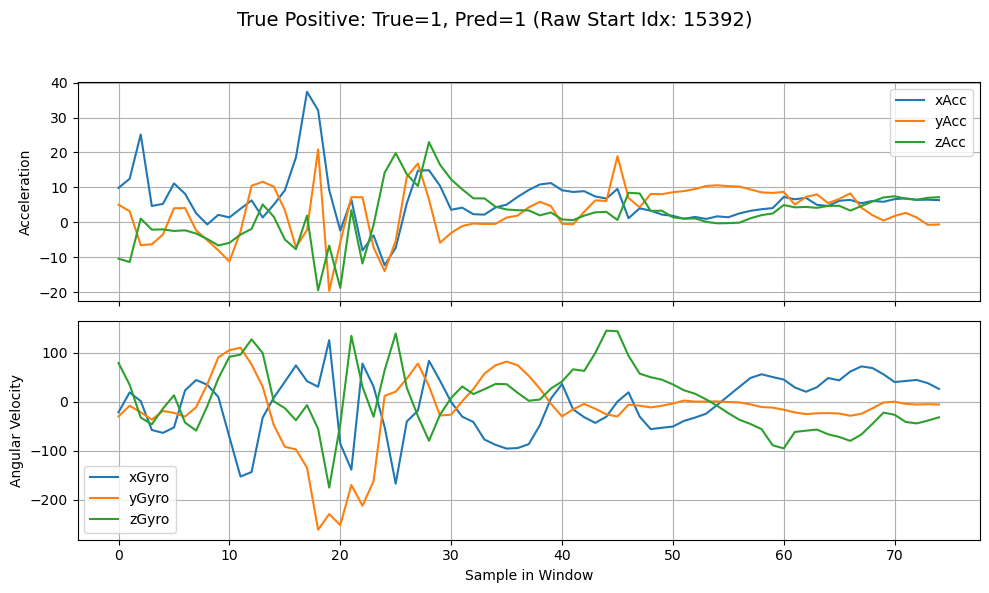


Plotting False Positive (found 20)...


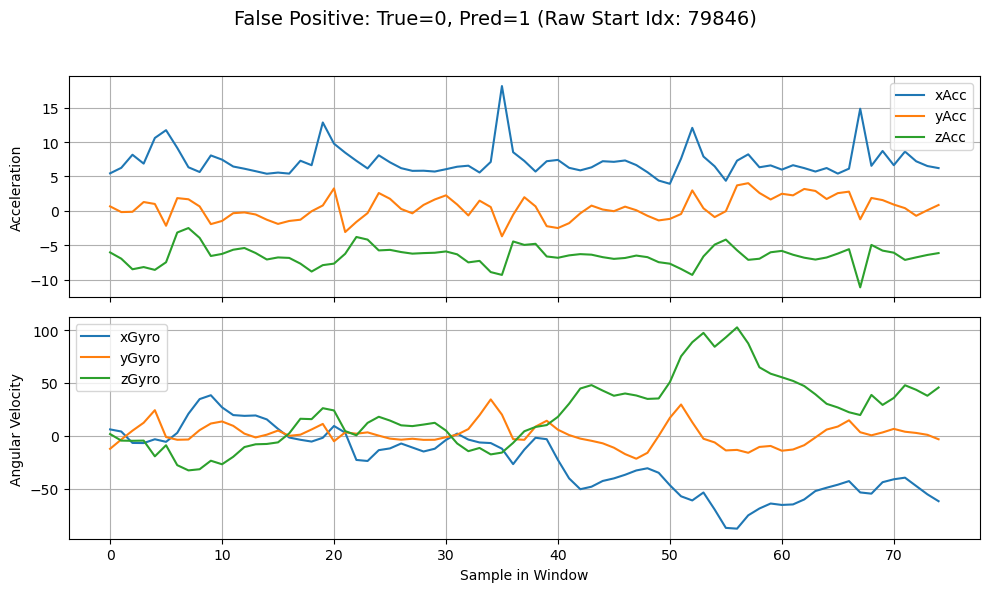


Plotting True Negative (found 538)...


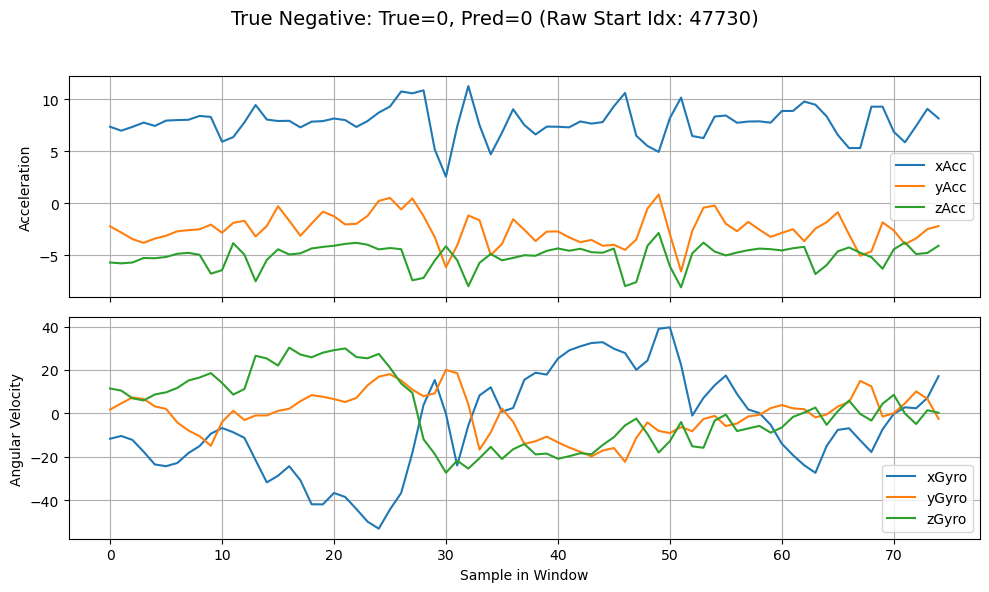


Plotting False Negative (found 44)...


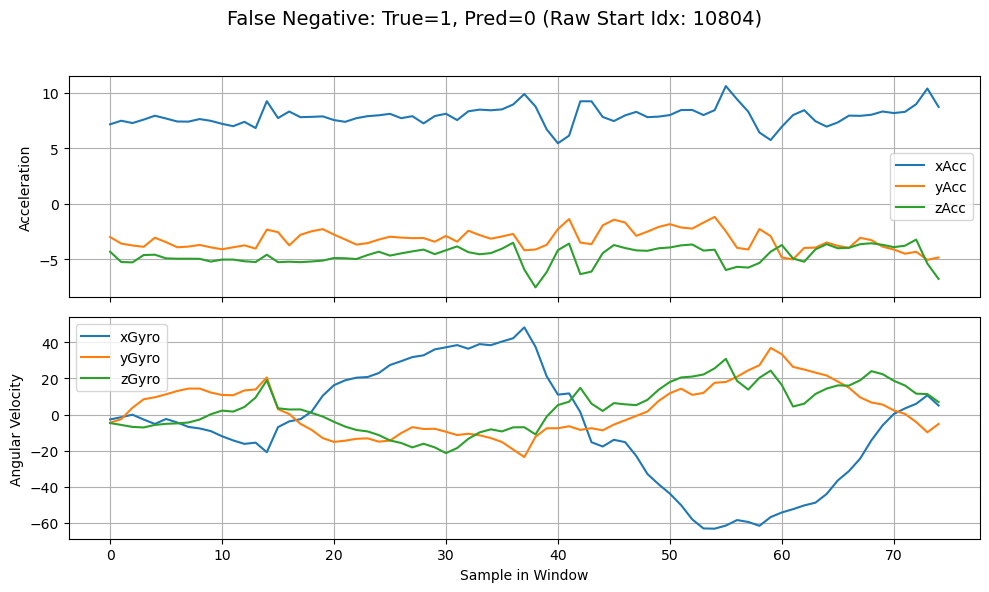

In [31]:
# ==============================================================================
# PART 2: ADVANCED FALL DETECTION (Accelerometer/Gyroscope Data)
# ==============================================================================
print("\n========================================================")
print("PART 2: ADVANCED FALL DETECTION (ACCELEROMETER/GYROSCOPE)")
print("========================================================")
from sklearn.ensemble import RandomForestClassifier # Ensuring import for this part

# Initialize fall model variables so they exist even if training is skipped
fall_model = None
scaler_fall = None # This is the scaler for *featured* data
# To store the column order of features the model was trained on:
X_fall_features_df_columns_trained = None


# --- Feature Extraction Function ---
def extract_windowed_features(df_segment, window_size, step_size, acc_cols, gyro_cols, label_col=None):
    all_window_features = []
    num_samples = len(df_segment)
    if num_samples < window_size:
        # print(f"Warning: Data segment length ({num_samples}) is less than window size ({window_size}). No windows extracted.")
        return pd.DataFrame(all_window_features)

    original_indices_map = [] 

    for i in range(0, num_samples - window_size + 1, step_size):
        window = df_segment.iloc[i : i + window_size]
        # Get the actual index from the original df_segment if its index is meaningful
        # This assumes df_segment's index corresponds to fall_df_raw's original index.
        # If fall_df_raw was reset_index() without dropping, then iloc[i] gives the right row,
        # and window.index[0] would be that original index.
        # If fall_df_raw has a simple RangeIndex, then df_segment.index[0] + i is more direct.
        # For simplicity, if fall_df_raw has its original index preserved, window.index[0] is fine.
        # If fall_df_raw might have a simple 0-based index after some operations, then
        # direct indexing into fall_df_raw based on 'i' might be needed carefully.
        # Let's assume the input df_segment passed to this function has an index that allows us
        # to retrieve the original start index from the full raw dataframe.
        raw_start_index_for_window = window.index[0]


        current_features = {}
        if label_col and label_col in window.columns:
            label_val = window[label_col].iloc[window_size // 2] # Label from center of window
            current_features[label_col] = int(label_val)

        if all(c in window.columns for c in acc_cols):
            smv_acc = np.sqrt(window[acc_cols[0]]**2 + window[acc_cols[1]]**2 + window[acc_cols[2]]**2)
            current_features['SMV_Acc_mean'] = smv_acc.mean(); current_features['SMV_Acc_std'] = smv_acc.std()
            current_features['SMV_Acc_min'] = smv_acc.min(); current_features['SMV_Acc_max'] = smv_acc.max()
            current_features['SMV_Acc_median'] = smv_acc.median(); current_features['SMV_Acc_iqr'] = smv_acc.quantile(0.75) - smv_acc.quantile(0.25)
            for col_name in acc_cols:
                current_features[f'{col_name}_mean'] = window[col_name].mean(); current_features[f'{col_name}_std'] = window[col_name].std()
                current_features[f'{col_name}_max_abs_diff'] = window[col_name].diff().abs().max()

        if all(c in window.columns for c in gyro_cols):
            smv_gyro = np.sqrt(window[gyro_cols[0]]**2 + window[gyro_cols[1]]**2 + window[gyro_cols[2]]**2)
            current_features['SMV_Gyro_mean'] = smv_gyro.mean(); current_features['SMV_Gyro_std'] = smv_gyro.std()
            current_features['SMV_Gyro_max'] = smv_gyro.max(); current_features['SMV_Gyro_iqr'] = smv_gyro.quantile(0.75) - smv_gyro.quantile(0.25)
            for col_name in gyro_cols:
                current_features[f'{col_name}_mean'] = window[col_name].mean(); current_features[f'{col_name}_std'] = window[col_name].std()
        
        min_expected_features = 1 if label_col and label_col in current_features else 0
        if len(current_features) > min_expected_features:
            all_window_features.append(current_features)
            original_indices_map.append(raw_start_index_for_window) # Store start index of raw window
            
    processed_df = pd.DataFrame(all_window_features)
    if not processed_df.empty:
         processed_df = processed_df.dropna(subset=[col for col in processed_df.columns if col != label_col], how='all')
         # Add the raw start indices as a new column or as the index
         if len(original_indices_map) == len(processed_df):
            processed_df['raw_start_index'] = original_indices_map
         else:
            # This case should ideally not happen if all_window_features appends match original_indices_map appends
            print("Warning: Mismatch between number of feature windows and original_indices_map length. 'raw_start_index' might be incorrect or missing.")
            if 'raw_start_index' in processed_df.columns: # If it somehow got created with wrong length
                processed_df = processed_df.drop(columns=['raw_start_index'])
    return processed_df

# --- Load Fall Dataset ---
print(f"\nAttempting to load fall dataset from: {FALL_DATASET_PATH}")
fall_df_raw = None
try:
    if not os.path.exists(FALL_DATASET_PATH): raise FileNotFoundError(f"Fall data file missing: {FALL_DATASET_PATH}")
    fall_df_raw = pd.read_csv(FALL_DATASET_PATH)
    print(f"Successfully loaded fall dataset: {FALL_DATASET_PATH}"); print("Fall dataset (raw) columns:", fall_df_raw.columns.tolist())
    if FALL_LABEL_COL not in fall_df_raw.columns: # FALL_LABEL_COL is 'label'
        print(f"CRITICAL: RAW CSV does NOT contain the label column '{FALL_LABEL_COL}'. Checking for 'Activity' column to derive labels...")
        if 'Activity' in fall_df_raw.columns:
            fall_df_raw[FALL_LABEL_COL] = fall_df_raw['Activity'].apply(lambda x:1 if isinstance(x,str) and 'FALL' in x.upper() else 0)
            print(f"Derived '{FALL_LABEL_COL}' from 'Activity' column.")
        else: raise KeyError(f"Label column '{FALL_LABEL_COL}' not found and no 'Activity' column present to derive it from.")
    
    print(f"\nOriginal unique values in '{FALL_LABEL_COL}' (before binary conversion, if applicable): {fall_df_raw[FALL_LABEL_COL].unique()}")
    fall_keywords = ['fall', 'rfall', 'lfall'] # Ensure this list covers all your fall-related string labels
    def map_to_binary_fall(activity_label):
        if isinstance(activity_label, str): # Check if it's a string first
            for keyword in fall_keywords:
                if keyword in activity_label.lower(): return 1
            return 0 # If string but not a fall keyword
        elif pd.api.types.is_numeric_dtype(activity_label): # If it's already numeric
             return int(activity_label) # Ensure it's int, handles existing 0/1
        return 0 # Default for other types or unhandled strings

    fall_df_raw[FALL_LABEL_COL] = fall_df_raw[FALL_LABEL_COL].apply(map_to_binary_fall)
    print(f"\nConverted '{FALL_LABEL_COL}' to binary (1 for fall, 0 for non-fall).")
    print(f"RAW Binary '{FALL_LABEL_COL}' distribution:"); print(fall_df_raw[FALL_LABEL_COL].value_counts(normalize=True)); print(fall_df_raw[FALL_LABEL_COL].value_counts())
    
    if not all(col in fall_df_raw.columns for col in FALL_FEATURE_COLS_RAW):
        raise ValueError(f"Missing one or more raw feature columns for fall detection: {FALL_FEATURE_COLS_RAW}")

except (FileNotFoundError, pd.errors.EmptyDataError, KeyError, ValueError) as e_load:
    print(f"Error loading or processing fall dataset '{FALL_DATASET_PATH}': {e_load}")
    print("Generating a DUMMY fall dataset as fallback...")
    n_rows_fall=10000
    fall_df_raw=pd.DataFrame(np.random.randn(n_rows_fall,len(FALL_FEATURE_COLS_RAW))*np.array([3,3,3,80,80,80]), columns=FALL_FEATURE_COLS_RAW)
    fall_df_raw['zAcc']-=9.8
    fall_df_raw[FALL_LABEL_COL]=0 # Initialize with 0
    num_dummy_falls_to_create=int(n_rows_fall*0.05)
    fall_event_len=SAMPLING_RATE_HZ//2
    for _ in range(num_dummy_falls_to_create):
        start_idx=np.random.randint(0,n_rows_fall-fall_event_len)
        fall_df_raw.loc[start_idx:start_idx+fall_event_len,FALL_LABEL_COL]=1
        for col in FALL_FEATURE_COLS_RAW[:3]: fall_df_raw.loc[start_idx:start_idx+fall_event_len,col]*=np.random.uniform(3,7)
        for col in FALL_FEATURE_COLS_RAW[3:]: fall_df_raw.loc[start_idx:start_idx+fall_event_len,col]*=np.random.uniform(2,6)
    print(f"Loaded DUMMY fall dataset. RAW '{FALL_LABEL_COL}' distribution:"); print(fall_df_raw[FALL_LABEL_COL].value_counts(normalize=True))

# --- Process Fall Data: Feature Extraction ---
fall_df_featured = pd.DataFrame()
if fall_df_raw is not None and FALL_LABEL_COL in fall_df_raw.columns and fall_df_raw[FALL_LABEL_COL].nunique() > 0:
    if not pd.api.types.is_numeric_dtype(fall_df_raw[FALL_LABEL_COL]):
        print(f"ERROR: Column '{FALL_LABEL_COL}' in fall_df_raw is NOT NUMERIC after processing. This indicates an issue in label conversion.")
    else:
        print(f"\nExtracting windowed features (Window: {WINDOW_SAMPLES}, Step: {STEP_SAMPLES})...");
        fall_df_featured = extract_windowed_features(fall_df_raw, WINDOW_SAMPLES, STEP_SAMPLES, FALL_FEATURE_COLS_RAW[:3], FALL_FEATURE_COLS_RAW[3:], FALL_LABEL_COL)
        if fall_df_featured.empty or FALL_LABEL_COL not in fall_df_featured.columns:
            print("Warning: No features extracted or label column missing from featured DataFrame after windowing. Fall detection part might be skipped.")
            fall_df_featured=pd.DataFrame()
        else:
            print(f"Extracted features from {len(fall_df_featured)} windows.")
            print(f"\nFeatured '{FALL_LABEL_COL}' distribution (after windowing):"); print(fall_df_featured[FALL_LABEL_COL].value_counts(normalize=True)); print(fall_df_featured[FALL_LABEL_COL].value_counts())
else:
    print("Skipping fall feature engineering due to issues with raw fall data or initial label column.")

# --- Model Training if Features Available & Diverse ---
if not fall_df_featured.empty and FALL_LABEL_COL in fall_df_featured.columns and 'raw_start_index' in fall_df_featured.columns and fall_df_featured[FALL_LABEL_COL].nunique() > 1:
    y_fall_labels_all_featured = fall_df_featured[FALL_LABEL_COL]
    X_fall_all_featured_df_with_indices = fall_df_featured.drop(columns=[FALL_LABEL_COL]) # This keeps raw_start_index
    
    # Define X_fall_features_df_columns_trained from the features that will be used for ML
    # This is before converting to numpy array
    temp_ml_features_df = X_fall_all_featured_df_with_indices.drop(columns=['raw_start_index'])
    X_fall_features_df_columns_trained = temp_ml_features_df.columns.tolist() # Save column order
    joblib.dump(X_fall_features_df_columns_trained, 'fall_feature_names_trained.pkl')
    print(f"Saved {len(X_fall_features_df_columns_trained)} fall feature names for inference: {X_fall_features_df_columns_trained[:5]}...")

    X_fall_all_featured_ml_ready = temp_ml_features_df.bfill().ffill().fillna(0) # Use updated fillna
    X_fall_features_values = X_fall_all_featured_ml_ready.values

    # Split the DataFrame that includes 'raw_start_index' to keep the mapping
    X_train_df_orig_idx, X_test_df_orig_idx, y_train_f_orig, y_test_f = train_test_split(
        X_fall_all_featured_df_with_indices, # Pass the DataFrame with raw_start_index
        y_fall_labels_all_featured,
        test_size=0.30, random_state=42, stratify=y_fall_labels_all_featured
    )
    test_raw_start_indices = X_test_df_orig_idx['raw_start_index'] # This is a Series
    X_test_f_orig_for_ml = X_test_df_orig_idx.drop(columns=['raw_start_index']).bfill().ffill().fillna(0).values
    X_train_f_orig_for_ml = X_train_df_orig_idx.drop(columns=['raw_start_index']).bfill().ffill().fillna(0).values


    if IMBLEARN_AVAILABLE:
        minority_count = pd.Series(y_train_f_orig).value_counts().min()
        k_smote = min(5, minority_count - 1) if minority_count > 1 else 1 # k must be < n_samples in minority class
        if k_smote >= 1 and pd.Series(y_train_f_orig).nunique() > 1: # Check if SMOTE is applicable
            print(f"\nApplying SMOTE to training data (k_neighbors={k_smote})...")
            smote = SMOTE(random_state=42, k_neighbors=k_smote)
            try:
                X_train_f_resampled, y_train_f_resampled = smote.fit_resample(X_train_f_orig_for_ml, y_train_f_orig)
                X_train_f_formodel, y_train_f = X_train_f_resampled, y_train_f_resampled
            except ValueError as e_smote:
                print(f"SMOTE Error: {e_smote}. Using original training data.")
                X_train_f_formodel, y_train_f = X_train_f_orig_for_ml, y_train_f_orig
        else:
            X_train_f_formodel, y_train_f = X_train_f_orig_for_ml, y_train_f_orig
            print("\nSkipping SMOTE (minority class too small or only one class in training data).")
    else:
        X_train_f_formodel, y_train_f = X_train_f_orig_for_ml, y_train_f_orig
        print("\nSMOTE not available (imblearn not installed).")
    print("Training distribution before SMOTE (if different from 'For Model'):"); print(pd.Series(y_train_f_orig).value_counts().to_dict())
    print("Training distribution for model (after SMOTE, if applied):"); print(pd.Series(y_train_f).value_counts().to_dict())


    scaler_fall = StandardScaler()
    X_train_f = scaler_fall.fit_transform(X_train_f_formodel)
    X_test_f = scaler_fall.transform(X_test_f_orig_for_ml)
    joblib.dump(scaler_fall, 'fall_detection_featured_scaler.pkl')

    print("\nTraining Fall Detection model (RandomForest with GridSearchCV)...")
    param_grid_rf = {
        'n_estimators':[100, 200, 300], 'max_depth':[10, 20, None],
        'min_samples_split':[2, 5, 10], 'min_samples_leaf':[1, 2, 4],
        'class_weight':['balanced', {0:1, 1:10}, {0:1, 1:15}, {0:1, 1:20}]
    }
    f1_fall_scorer = make_scorer(f1_score,pos_label=1,average='binary') # Score for 'fall' class
    
    if pd.Series(y_train_f).nunique() > 1: # Ensure GridSearchCV can run with cross-validation
        grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42,n_jobs=-1), param_grid_rf, cv=3, scoring=f1_fall_scorer, verbose=1)
        grid_search_rf.fit(X_train_f, y_train_f)
        print("Best params for Fall RF:", grid_search_rf.best_params_)
        fall_model = grid_search_rf.best_estimator_
    else:
        print("Only one class in y_train_f for model. Training basic RF without GridSearchCV.")
        fall_model = RandomForestClassifier(n_estimators=150,random_state=42,class_weight='balanced',n_jobs=-1)
        if X_train_f.shape[0]>0:
            fall_model.fit(X_train_f,y_train_f)
        else:
            print("No training data available for basic RF. Fall model not trained.")
            fall_model = None # Ensure fall_model is None


    if X_train_f.shape[0] > 0 and fall_model is not None and hasattr(fall_model, 'predict'):
        joblib.dump(fall_model, 'fall_detection_model.pkl')
        print("Trained Fall Detection model saved.")
        print("\nEvaluating Fall Detection model...")
        y_pred_f = fall_model.predict(X_test_f)
        y_pred_proba_f = fall_model.predict_proba(X_test_f)[:,1]

        print("\nClassification Report (Fall Detection - Tuned RF):")
        print(classification_report(y_test_f, y_pred_f, target_names=['No Fall (0)','Fall (1)'], digits=4, zero_division=0))
        
        cm_f = confusion_matrix(y_test_f,y_pred_f)
        plt.figure(figsize=(7,5))
        sns.heatmap(cm_f,annot=True,fmt='d',cmap='Greens',xticklabels=['No Fall','Fall'],yticklabels=['No Fall','Fall'])
        plt.title('Confusion Matrix - Fall Detection'); plt.xlabel('Predicted'); plt.ylabel('True');
        plt.show()
        
        # --- Raw Sensor Data Plotting (as you had it) ---
        print("\n--- Visualizing Raw Sensor Data for Prediction Outcomes ---")
        def plot_raw_sensor_window_outcome(raw_data_df, start_idx, window_len, true_label, pred_label, outcome_type):
            # ... (function definition as in your last working version) ...
            if start_idx is None or pd.isna(start_idx): print(f"Invalid start_idx (None or NaN) for {outcome_type}"); return
            start_idx = int(start_idx) # Ensure it's an integer
            if start_idx + window_len > len(raw_data_df): print(f"Not enough raw data for window starting at {start_idx} for {outcome_type}, requested {window_len}, available from start {len(raw_data_df)-start_idx}"); return
            raw_window_to_plot = raw_data_df.iloc[start_idx : start_idx + window_len]
            if raw_window_to_plot.empty or len(raw_window_to_plot)<2: print(f"Empty/short raw window for {outcome_type} at index {start_idx}"); return
            fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,6),sharex=True); title=f"{outcome_type}: True={true_label}, Pred={pred_label} (Raw Start Idx: {start_idx})"; fig.suptitle(title,fontsize=14); time_idx_plot=np.arange(len(raw_window_to_plot))
            for acc_col in FALL_FEATURE_COLS_RAW[:3]: ax1.plot(time_idx_plot, raw_window_to_plot[acc_col], label=acc_col)
            ax1.set_ylabel('Acceleration'); ax1.legend(); ax1.grid(True)
            for gyro_col in FALL_FEATURE_COLS_RAW[3:]: ax2.plot(time_idx_plot, raw_window_to_plot[gyro_col], label=gyro_col)
            ax2.set_ylabel('Angular Velocity'); ax2.set_xlabel('Sample in Window'); ax2.legend(); ax2.grid(True)
            plt.tight_layout(rect=[0,0,1,0.95]); plt.show()

        num_examples_to_plot = 1 # Plot 1 example for each category for brevity
        for outcome, true_val, pred_val in [("True Positive",1,1), ("False Positive",0,1), ("True Negative",0,0), ("False Negative",1,0)]:
            # Get indices from the original y_test_f Series/array for comparison with y_pred_f
            indices_in_y_test = np.where((y_test_f == true_val) & (y_pred_f == pred_val))[0]
            print(f"\nPlotting {outcome} (found {len(indices_in_y_test)})...")
            
            if 'test_raw_start_indices' in locals() and isinstance(test_raw_start_indices, pd.Series) and not test_raw_start_indices.empty:
                # Use the indices from y_test_f to select corresponding raw_start_indices from test_raw_start_indices
                # test_raw_start_indices should have the same index as X_test_df_orig_idx before it became a numpy array
                # and y_test_f corresponds to rows of X_test_f_orig_for_ml (and thus X_test_df_orig_idx)
                
                # Get the original DataFrame indices that correspond to our test set
                original_df_indices_for_test = X_test_df_orig_idx.index[indices_in_y_test]

                for df_idx in original_df_indices_for_test[:num_examples_to_plot]:
                    raw_idx_start = X_test_df_orig_idx.loc[df_idx, 'raw_start_index']
                    plot_raw_sensor_window_outcome(fall_df_raw, raw_idx_start, WINDOW_SAMPLES, true_val, pred_val, outcome)
            elif len(indices_in_y_test) > 0:
                 print(f"Warning: test_raw_start_indices not properly available for plotting {outcome}.")
    else:
        print("Skipping evaluation and raw data plotting for fall model as it was not trained or no training data.")
        X_fall_features_df_columns_trained = None # Ensure it's None if this block is skipped

elif not fall_df_featured.empty and FALL_LABEL_COL in fall_df_featured.columns and fall_df_featured[FALL_LABEL_COL].nunique()<=1:
    print(f"\nSkipping Fall Model Training & Plotting: Featured dataset has only one class ('{fall_df_featured[FALL_LABEL_COL].unique()[0] if len(fall_df_featured[FALL_LABEL_COL].unique()) > 0 else 'N/A'}') after windowing.")
    X_fall_features_df_columns_trained = None # Ensure it's None
else:
    print("\nSkipping Advanced Fall Detection & Plotting: Critical issues with data loading/processing.")
    X_fall_features_df_columns_trained = None # Ensure it's None

In [62]:
# Make sure these are defined globally or passed if these sections are functions
# From your main script PART 1:
# model_vitals_lstm, scaler_vitals, label_encoder_vitals, TIME_STEPS_VITALS
# From your main script PART 2:
# fall_model, scaler_fall, X_fall_features_df_columns_trained, WINDOW_SAMPLES, FALL_FEATURE_COLS_RAW

# --- Vitals Anomaly Check with RANDOMLY GENERATED Values ---
print("\n========================================================")
print("PART 1B: VITALS ANOMALY CHECK (RANDOMIZED INPUTS)")
print("========================================================")

if 'model_vitals_lstm' in locals() and model_vitals_lstm is not None and \
   'scaler_vitals' in locals() and scaler_vitals is not None and \
   'label_encoder_vitals' in locals() and label_encoder_vitals is not None and \
   'TIME_STEPS_VITALS' in locals():
    print("Using Vitals models and preprocessors from current session for anomaly check.")

    def generate_random_vitals_sequence(length, scenario="normal"):
        sequence = []
        for _ in range(length):
            hr, spo2, temp = 0, 0, 0.0
            if scenario == "normal_vitals":
                hr = np.random.randint(65, 85)      # Normal HR range
                spo2 = np.random.randint(96, 100)   # Normal SpO2
                temp = np.random.uniform(36.5, 37.2) # Normal Temp
            elif scenario == "medium_risk_vitals":
                # Trigger based on your create_risk_labels_vitals logic for "Medium"
                # Example: HR > 90 OR SpO2 < 94 (assuming these are part of your Medium risk def)
                if np.random.rand() < 0.7: # 70% chance to make HR high for medium
                    hr = np.random.randint(91, 99) # e.g. HR for Medium
                    spo2 = np.random.randint(95, 98)
                else: # Or make SpO2 low for medium
                    hr = np.random.randint(70, 85)
                    spo2 = np.random.randint(91, 94) # e.g. SpO2 for Medium
                temp = np.random.uniform(36.5, 37.4)
            elif scenario == "high_risk_vitals":
                # Trigger based on your create_risk_labels_vitals logic for "High"
                # Example: HR > 100 OR SpO2 < 90
                if np.random.rand() < 0.7: # 70% chance very high HR
                    hr = np.random.randint(101, 120) # e.g. HR for High
                    spo2 = np.random.randint(90, 95)
                else: # Or very low SpO2
                    hr = np.random.randint(70, 90)
                    spo2 = np.random.randint(85, 90) # e.g. SpO2 for High
                temp = np.random.uniform(37.0, 38.5) # Temp might also be elevated
            sequence.append((hr, spo2, round(temp, 1)))
        return sequence

    test_scenarios_vitals = ["normal_vitals", "medium_risk_vitals", "high_risk_vitals", "normal_vitals", "medium_risk_vitals"]

    for i, scenario in enumerate(test_scenarios_vitals):
        print(f"\n--- Vitals Test Case {i+1}: Generating for '{scenario}' scenario ---")
        custom_vitals_sequence_raw = generate_random_vitals_sequence(TIME_STEPS_VITALS, scenario=scenario)
        # print(f"Generated sequence: {custom_vitals_sequence_raw}") # Uncomment to see data

        scaled_custom_sequence_data = scaler_vitals.transform(np.array(custom_vitals_sequence_raw))
        lstm_custom_input_sequence = np.array([scaled_custom_sequence_data])
        custom_probabilities = model_vitals_lstm.predict(lstm_custom_input_sequence, verbose=0)[0]
        custom_predicted_idx = np.argmax(custom_probabilities)
        
        if custom_predicted_idx < len(label_encoder_vitals.classes_):
            custom_predicted_label = label_encoder_vitals.classes_[custom_predicted_idx]
            is_custom_anomaly = custom_predicted_label != "Normal" # Adjust if "Normal" is not your only non-anomalous state
            print(f"  -> Predicted Risk: {custom_predicted_label}, Is Anomaly: {is_custom_anomaly}")
            print(f"     Probabilities: {dict(zip(label_encoder_vitals.classes_, custom_probabilities.round(3)))}")
        else:
            print(f"  Error: Predicted index {custom_predicted_idx} out of bounds for label encoder classes {label_encoder_vitals.classes_}.")
            print(f"     Probabilities: {custom_probabilities}")
else:
    print("Vitals models/preprocessors were not trained/created in Part 1. Skipping anomaly check.")


PART 1B: VITALS ANOMALY CHECK (RANDOMIZED INPUTS)
Using Vitals models and preprocessors from current session for anomaly check.

--- Vitals Test Case 1: Generating for 'normal_vitals' scenario ---
  -> Predicted Risk: Normal, Is Anomaly: False
     Probabilities: {'Medium': 0.0, 'Normal': 1.0}

--- Vitals Test Case 2: Generating for 'medium_risk_vitals' scenario ---
  -> Predicted Risk: Medium, Is Anomaly: True
     Probabilities: {'Medium': 1.0, 'Normal': 0.0}

--- Vitals Test Case 3: Generating for 'high_risk_vitals' scenario ---
  -> Predicted Risk: Medium, Is Anomaly: True
     Probabilities: {'Medium': 1.0, 'Normal': 0.0}

--- Vitals Test Case 4: Generating for 'normal_vitals' scenario ---
  -> Predicted Risk: Normal, Is Anomaly: False
     Probabilities: {'Medium': 0.0, 'Normal': 1.0}

--- Vitals Test Case 5: Generating for 'medium_risk_vitals' scenario ---
  -> Predicted Risk: Normal, Is Anomaly: False
     Probabilities: {'Medium': 0.0, 'Normal': 1.0}


In [64]:
# --- Fall Detection Check with RANDOMLY GENERATED Values ---
print("\n========================================================")
print("PART 2B: FALL DETECTION CHECK (RANDOMIZED INPUTS - INTENSE DEBUG)")
print("========================================================")

if 'fall_model' in locals() and fall_model is not None and \
   'scaler_fall' in locals() and scaler_fall is not None and \
   'X_fall_features_df_columns_trained' in locals() and X_fall_features_df_columns_trained is not None and \
   'WINDOW_SAMPLES' in locals() and 'FALL_FEATURE_COLS_RAW' in locals():
    print("Using Fall Detection model, scaler, and feature names from current session for check.")
    print(f"DEBUG 2B: Expected feature order (first 10): {X_fall_features_df_columns_trained[:10]}")
    print(f"DEBUG 2B: Total expected features: {len(X_fall_features_df_columns_trained)}")


    # --- (Keep your existing extract_single_window_features_for_inference_fall function here) ---
    # --- (And your generate_random_imu_sequence function here) ---
    def extract_single_window_features_for_inference_fall(raw_data_segment_df, window_size, acc_cols, gyro_cols, trained_feature_order_list):
        # ... (Your robust version from the previous message, including print statements if you added them there) ...
        if len(raw_data_segment_df) < window_size: print("DEBUG EXTRACTOR: Not enough raw data for window."); return None
        window = raw_data_segment_df.iloc[-window_size:]
        current_features = {}
        # ACCELEROMETER
        if all(c in window.columns for c in acc_cols):
            window_acc_vals_no_nan = window[acc_cols].dropna()
            if not window_acc_vals_no_nan.empty:
                smv_acc = np.sqrt(window_acc_vals_no_nan[acc_cols[0]]**2 + window_acc_vals_no_nan[acc_cols[1]]**2 + window_acc_vals_no_nan[acc_cols[2]]**2)
                if not smv_acc.empty:
                    current_features['SMV_Acc_mean'] = smv_acc.mean(); current_features['SMV_Acc_std'] = smv_acc.std(ddof=0)
                    current_features['SMV_Acc_min'] = smv_acc.min(); current_features['SMV_Acc_max'] = smv_acc.max()
                    current_features['SMV_Acc_median'] = smv_acc.median()
                    current_features['SMV_Acc_iqr'] = smv_acc.quantile(0.75) - smv_acc.quantile(0.25) if len(smv_acc) > 1 else 0
            for col_name in acc_cols:
                if not window[col_name].dropna().empty:
                    current_features[f'{col_name}_mean'] = window[col_name].mean(); current_features[f'{col_name}_std'] = window[col_name].std(ddof=0)
                    diff_vals = window[col_name].diff().abs()
                    current_features[f'{col_name}_max_abs_diff'] = diff_vals.max() if not diff_vals.dropna().empty else 0
        # GYROSCOPE
        if all(c in window.columns for c in gyro_cols):
            window_gyro_vals_no_nan = window[gyro_cols].dropna()
            if not window_gyro_vals_no_nan.empty:
                smv_gyro = np.sqrt(window_gyro_vals_no_nan[gyro_cols[0]]**2 + window_gyro_vals_no_nan[gyro_cols[1]]**2 + window_gyro_vals_no_nan[gyro_cols[2]]**2)
                if not smv_gyro.empty:
                    current_features['SMV_Gyro_mean'] = smv_gyro.mean(); current_features['SMV_Gyro_std'] = smv_gyro.std(ddof=0)
                    current_features['SMV_Gyro_max'] = smv_gyro.max()
                    current_features['SMV_Gyro_iqr'] = smv_gyro.quantile(0.75) - smv_gyro.quantile(0.25) if len(smv_gyro) > 1 else 0
            for col_name in gyro_cols:
                if not window[col_name].dropna().empty:
                    current_features[f'{col_name}_mean'] = window[col_name].mean(); current_features[f'{col_name}_std'] = window[col_name].std(ddof=0)
        if not current_features: print("DEBUG EXTRACTOR: No features extracted."); return None
        feature_series = pd.Series(current_features)
        # print(f"DEBUG EXTRACTOR: Generated features before reindex (first 5): {feature_series.head().to_dict()}")
        try:
            ordered_features_df = pd.DataFrame([feature_series.reindex(trained_feature_order_list).fillna(0)])
            # print(f"DEBUG EXTRACTOR: Features after reindex (first 5 values): {ordered_features_df.iloc[0, :5].to_dict()}")
            return ordered_features_df
        except Exception as e_reindex: print(f"DEBUG EXTRACTOR: Error reindexing: {e_reindex}"); return None

    def generate_random_imu_sequence(length, scenario="adl_gentle"):
        # ... (Your generate_random_imu_sequence function) ...
        sequence = []
        if scenario == "fall_like_strong":
            calm_duration = max(0, length - np.random.randint(10, 15)); fall_event_duration = length - calm_duration
            for _ in range(calm_duration): sequence.append((np.random.normal(0,0.3),np.random.normal(0,0.3),np.random.normal(-9.8,0.3),np.random.normal(0,10),np.random.normal(0,10),np.random.normal(0,10)))
            for _ in range(fall_event_duration): sequence.append((np.random.uniform(15,30)*np.random.choice([-1,1]), np.random.uniform(15,30)*np.random.choice([-1,1]), np.random.normal(-2,10)+np.random.uniform(-10,10), np.random.uniform(200,450)*np.random.choice([-1,1]), np.random.uniform(200,450)*np.random.choice([-1,1]), np.random.uniform(200,450)*np.random.choice([-1,1])))
        elif scenario == "adl_vigorous_short_bursts":
            for i in range(length):
                if 20 < i < 35 or 50 < i < 65 : acc_x=np.random.uniform(-7,7); acc_y=np.random.uniform(-7,7); acc_z=-9.8+np.random.uniform(-5,5); gyro_x=np.random.uniform(-150,150); gyro_y=np.random.uniform(-150,150); gyro_z=np.random.uniform(-150,150)
                else: acc_x=np.random.normal(0,0.5); acc_y=np.random.normal(0,0.5); acc_z=np.random.normal(-9.8,0.5); gyro_x=np.random.normal(0,10); gyro_y=np.random.normal(0,10); gyro_z=np.random.normal(0,10)
                sequence.append((acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z))
        else: # adl_gentle
            for _ in range(length): sequence.append((np.random.normal(0,0.5),np.random.normal(0,0.5),np.random.normal(-9.8,0.5),np.random.normal(0,15),np.random.normal(0,15),np.random.normal(0,15)))
        return sequence


    # # --- RIGOROUS DEBUG FOR ONE SCENARIO ---
    # print("\n--- RIGOROUS DEBUG FOR 'fall_like_strong' SCENARIO ---")
    # debug_scenario = "fall_like_strong"
    
    # # 1. Generate Raw Data
    # custom_fall_raw_data_list_debug = generate_random_imu_sequence(WINDOW_SAMPLES, scenario=debug_scenario)
    # custom_fall_raw_df_segment_debug = pd.DataFrame(custom_fall_raw_data_list_debug, columns=FALL_FEATURE_COLS_RAW)
    # print(f"DEBUG 2B: Raw data for '{debug_scenario}' (first 5 rows):\n{custom_fall_raw_df_segment_debug.head()}")
    # print(f"DEBUG 2B: Raw data for '{debug_scenario}' (last 5 rows for fall part):\n{custom_fall_raw_df_segment_debug.tail()}")
    # print(f"DEBUG 2B: Raw data for '{debug_scenario}' describe:\n{custom_fall_raw_df_segment_debug.describe()}")

    # # 2. Extract Features
    # custom_extracted_features_df_debug = extract_single_window_features_for_inference_fall(
    #     custom_fall_raw_df_segment_debug, WINDOW_SAMPLES,
    #     FALL_FEATURE_COLS_RAW[:3], FALL_FEATURE_COLS_RAW[3:],
    #     X_fall_features_df_columns_trained
    # )
    # if custom_extracted_features_df_debug is None or custom_extracted_features_df_debug.empty:
    #     print("DEBUG 2B: ERROR - No features extracted for debug scenario.")
    # else:
    #     print(f"DEBUG 2B: Extracted Features for '{debug_scenario}' (BEFORE scaling):\n{custom_extracted_features_df_debug}")
    #     # Check for all zeros
    #     if (custom_extracted_features_df_debug == 0).all().all():
    #         print("DEBUG 2B: WARNING - Extracted features are ALL ZEROS.")
        
    #     # 3. Scale Features
    #     try:
    #         # Ensure passing NumPy array to scaler if that's how it was fit
    #         features_to_scale_np_debug = custom_extracted_features_df_debug.values
    #         custom_scaled_features_debug = scaler_fall.transform(features_to_scale_np_debug)
    #         print(f"DEBUG 2B: Scaled Features for '{debug_scenario}' (first 5 values of array):\n{custom_scaled_features_debug[0, :5]}")
    #         if np.allclose(custom_scaled_features_debug, np.zeros_like(custom_scaled_features_debug)):
    #              print("DEBUG 2B: WARNING - Scaled features are ALL (or close to) ZEROS.")
    #         elif np.isnan(custom_scaled_features_debug).any():
    #              print("DEBUG 2B: WARNING - Scaled features CONTAIN NaNs.")


    #         # 4. Predict
    #         custom_fall_prediction_debug = fall_model.predict(custom_scaled_features_debug)[0]
    #         custom_fall_proba_debug = fall_model.predict_proba(custom_scaled_features_debug)[0][1]
    #         fall_status_custom_debug = "Fall Detected" if custom_fall_prediction_debug == 1 else "No Fall"
    #        # In Part 2B, after custom_fall_proba_debug is calculated
    #         T_optimal = 0.35 # Example: Replace with the threshold you found from your PR curve
    #         custom_fall_prediction_with_new_thresh = 1 if custom_fall_proba_debug >= T_optimal else 0
    #         new_status = "Fall Detected" if custom_fall_prediction_with_new_thresh == 1 else "No Fall"
    #         print(f"DEBUG 2B: With Optimal Threshold {T_optimal} -> Prediction: {new_status} (Label: {custom_fall_prediction_with_new_thresh})")

    #     except ValueError as e_inf:
    #         print(f"DEBUG 2B: Error during scaling/prediction for '{debug_scenario}': {e_inf}")
    #         print(f"  Features passed to scaler shape: {custom_extracted_features_df_debug.shape}")
    #         print(f"  Scaler expected features: {scaler_fall.n_features_in_ if hasattr(scaler_fall, 'n_features_in_') else 'N/A'}")
    #     except Exception as e_gen_dbg:
    #          print(f"DEBUG 2B: A general error in debug block: {e_gen_dbg}")
    
    # print("--- END OF RIGOROUS DEBUG FOR ONE SCENARIO ---")


    #--- Original Loop for Multiple Scenarios (can be commented out during intense debug) ---
    test_scenarios_fall = ["adl_gentle", "adl_vigorous_short_bursts", "fall_like_strong", "adl_gentle", "fall_like_strong", "adl_vigorous_short_bursts"]
    for i, scenario in enumerate(test_scenarios_fall):
        print(f"\n--- Fall Test Case {i+1}: Generating IMU for '{scenario}' scenario ---")
        custom_fall_raw_data_list = generate_random_imu_sequence(WINDOW_SAMPLES, scenario=scenario)
        custom_fall_raw_df_segment = pd.DataFrame(custom_fall_raw_data_list, columns=FALL_FEATURE_COLS_RAW)

        custom_extracted_features_df = extract_single_window_features_for_inference_fall(
            custom_fall_raw_df_segment, WINDOW_SAMPLES,
            FALL_FEATURE_COLS_RAW[:3], FALL_FEATURE_COLS_RAW[3:],
            X_fall_features_df_columns_trained
        )
        if custom_extracted_features_df is not None and not custom_extracted_features_df.empty:
            try:
                features_to_scale_np = custom_extracted_features_df.values # Use .values
                custom_scaled_features = scaler_fall.transform(features_to_scale_np) # Pass NumPy array
                custom_fall_prediction = fall_model.predict(custom_scaled_features)[0]
                custom_fall_proba = fall_model.predict_proba(custom_scaled_features)[0][1]
                fall_status_custom = "Fall Detected" if custom_fall_prediction == 1 else "No Fall"
                print(f"  -> Prediction: {fall_status_custom} (Label: {custom_fall_prediction}), Prob of Fall: {custom_fall_proba:.4f}")
            except ValueError as e_inf: print(f"  Error during prediction: {e_inf}. Features given: {custom_extracted_features_df.columns.tolist()}. Scaler expects {scaler_fall.n_features_in_ if hasattr(scaler_fall, 'n_features_in_') else 'N/A'}")
            except Exception as e_gen: print(f"  A general error occurred: {e_gen}")
        else: print("  Could not extract features from custom IMU data.")
else:
    print("Fall detection model/scaler/feature_names were not trained/created or available in Part 2. Skipping custom fall check.")


PART 2B: FALL DETECTION CHECK (RANDOMIZED INPUTS - INTENSE DEBUG)
Using Fall Detection model, scaler, and feature names from current session for check.
DEBUG 2B: Expected feature order (first 10): ['SMV_Acc_mean', 'SMV_Acc_std', 'SMV_Acc_min', 'SMV_Acc_max', 'SMV_Acc_median', 'SMV_Acc_iqr', 'xAcc_mean', 'xAcc_std', 'xAcc_max_abs_diff', 'yAcc_mean']
DEBUG 2B: Total expected features: 25

--- Fall Test Case 1: Generating IMU for 'adl_gentle' scenario ---
  -> Prediction: No Fall (Label: 0), Prob of Fall: 0.4867

--- Fall Test Case 2: Generating IMU for 'adl_vigorous_short_bursts' scenario ---
  -> Prediction: Fall Detected (Label: 1), Prob of Fall: 0.5833

--- Fall Test Case 3: Generating IMU for 'fall_like_strong' scenario ---
  -> Prediction: No Fall (Label: 0), Prob of Fall: 0.3900

--- Fall Test Case 4: Generating IMU for 'adl_gentle' scenario ---
  -> Prediction: No Fall (Label: 0), Prob of Fall: 0.4733

--- Fall Test Case 5: Generating IMU for 'fall_like_strong' scenario ---
  -> 